# Buyer's Time Prediction Challenge (MachineHack)

#### Overview

Buyers spend a significant amount of time surfing an e-commerce store, since the pandemic the e-commerce has seen a boom in the number of users across the domains. In the meantime, the store owners are also planning to attract customers using various algorithms to leverage customer behavior patterns

Tracking customer activity is also a great way of understanding customer behavior and figuring out what can actually be done to serve them better. Machine learning and AI has already played a significant role in designing various recommendation engines to lure customers by predicting their buying patterns

In this competition provided the visitor's session data, we are challenging the Machinehack community to come up with a regression algorithm to predict the time a buyer will spend on the platform.

#### Attribute Description:

* session_id - Unique identifier for every row
* session_number - Session type identifier
* client_agent - Client-side software details
* device_details -  Client-side device details
* date - Datestamp of the session
* purchased - Binary value for any purchase done
* added_in_cart - Binary value for cart activity
* checked_out -  Binary value for checking out successfully
* time_spent - Total time spent in seconds (Target Column)

 
#### Skills:

* Regression Modeling
* Advance Feature engineering, with Datestamp and Text datatypes
* Optimizing RMSLE score as a metric to generalize well on unseen data

###### python libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

###### data visualization libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization and Feature Engineering

In [3]:
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      5429 non-null   object 
 1   session_number  5429 non-null   int64  
 2   client_agent    5269 non-null   object 
 3   device_details  5429 non-null   object 
 4   date            5429 non-null   object 
 5   purchased       5429 non-null   int64  
 6   added_in_cart   5429 non-null   int64  
 7   checked_out     5429 non-null   int64  
 8   time_spent      5429 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 381.9+ KB


### We will convert the time_spent (seconds) into mins. During prediction we will multiply our predicted values with 60 to convert to seconds.

In [5]:
train['time_spent'].head()

0     236.886
1    1277.455
2      21.704
3     455.201
4    1164.877
Name: time_spent, dtype: float64

In [6]:
train['time_spent'] = train['time_spent']/60
train['time_spent'].head()

0     3.948100
1    21.290917
2     0.361733
3     7.586683
4    19.414617
Name: time_spent, dtype: float64

###### Changing datatype of date column

In [7]:
train['date'] = train['date'].astype('datetime64')
test['date'] = test['date'].astype('datetime64')

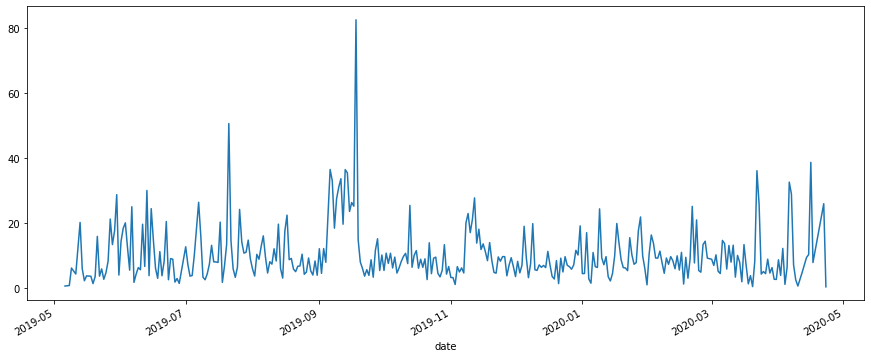

In [8]:
plt.figure(figsize = (15,6))
train.groupby('date')['time_spent'].mean().plot()
plt.show()

# There are outliers between 2019-09 and 2019-11 that has spent close to 5000 units

###### Let us convert the date column into seperate columns

In [9]:
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['dayofweek'] = train['date'].dt.dayofweek
train['year'] = train['date'].dt.year
train['weekofyear'] = train['date'].dt.week
train['dayofyear'] = ((train['weekofyear']*7)-7)+train['dayofweek']

In [10]:
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['dayofweek'] = test['date'].dt.dayofweek
test['year'] = test['date'].dt.year
test['weekofyear'] = test['date'].dt.weekofyear
test['dayofyear'] = ((test['weekofyear']*7)-7)+test['dayofweek']

# Now let us look at the trend of time_spent across a year

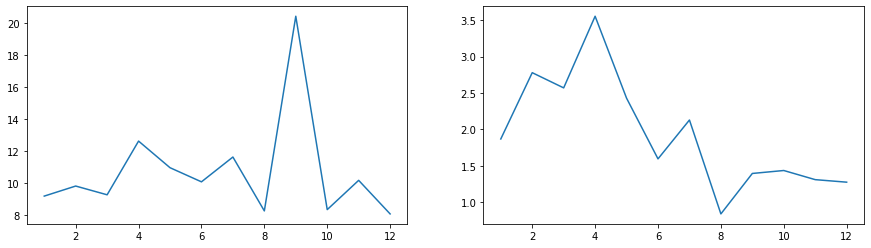

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,4))
mn = train.groupby('month')['time_spent'].mean()
mdn = train.groupby('month')['time_spent'].median()
ax[0].plot(mn)
ax[1].plot(mdn)
plt.show()

##### Month 9 seems to exhibit some odd characteristic. It is too high compared to the rest of the data. We will handle outliers in this particular month first and regraph the trend of time_spent by mean and median

Text(0, 0.5, 'time spent in hrs')

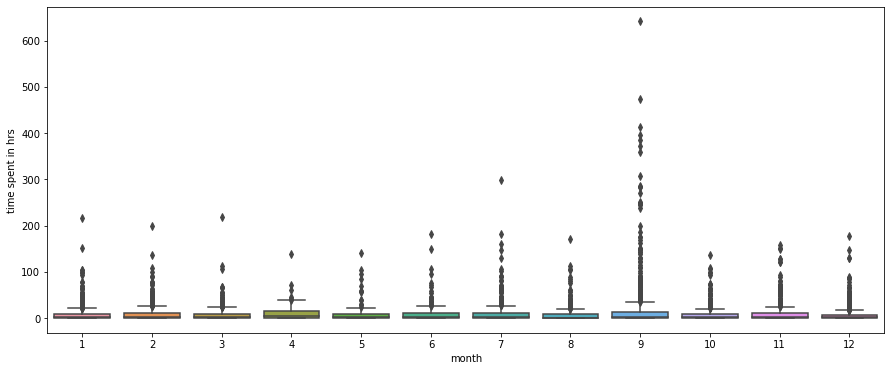

In [12]:
plt.figure(figsize = (15,6))
sns.boxplot('month','time_spent',data = train)
plt.ylabel('time spent in hrs')

###### 600 mins for a session on an ecommerce website! I don't think so..

In [13]:
max(train['time_spent'])

641.5670833333334

In [14]:
def outlier_param(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3-Q1
    return Q3+(1.5*IQR)

###### If I were to remove outliers based on the 9th month we would lose 1082 records.

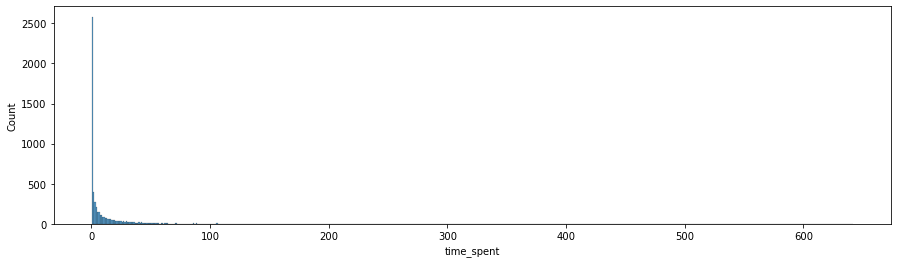

In [15]:
plt.figure(figsize = (15,4))
sns.histplot(train['time_spent'])

In [16]:
o = outlier_param(train['time_spent'])
o

24.451816666666677

###### 24 mins seems to be an ok time but we could go higher and check while modelling

In [17]:
train = train[train['time_spent']<=20]

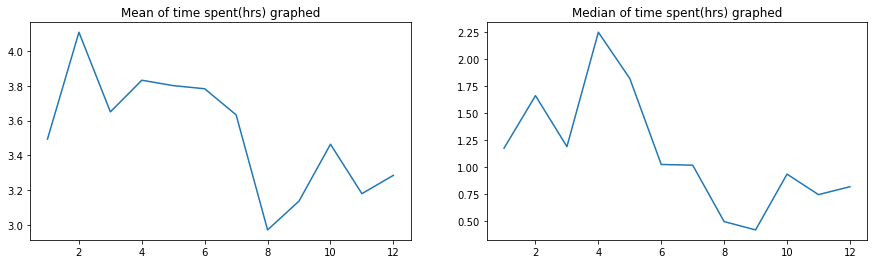

In [18]:
fig,ax = plt.subplots(1,2,figsize = (15,4))
mn = train.groupby('month')['time_spent'].mean()
mdn = train.groupby('month')['time_spent'].median()
ax[0].plot(mn)
ax[0].set_title('Mean of time spent(hrs) graphed')
ax[1].plot(mdn)
ax[1].set_title('Median of time spent(hrs) graphed')
plt.show()

###### Compared to before our mean and median graphs look more similar or follow a similar trend.

###### Let us look at the month vs time_spent boxplot again

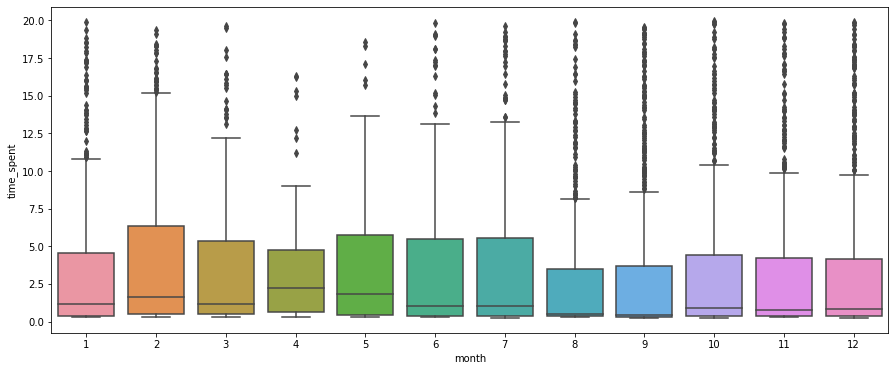

In [19]:
plt.figure(figsize = (15,6))
sns.boxplot('month','time_spent',data = train)

###### Since the data is day wise I assume that a session does not go over a day or should not go over a day. If it is going over a day it means that the logging system is faulty. It could be possible that a person left the website on at his end but most probably our backend system is considering a customer to stayed logged in while in reality he is not.

###### For the rest of the outliers in the data set we will apply a log transformation to the time_spent column  to further remove any outliers. 

In [20]:
train['time_spent'] = np.log(train['time_spent'])

C:\Users\tejas\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


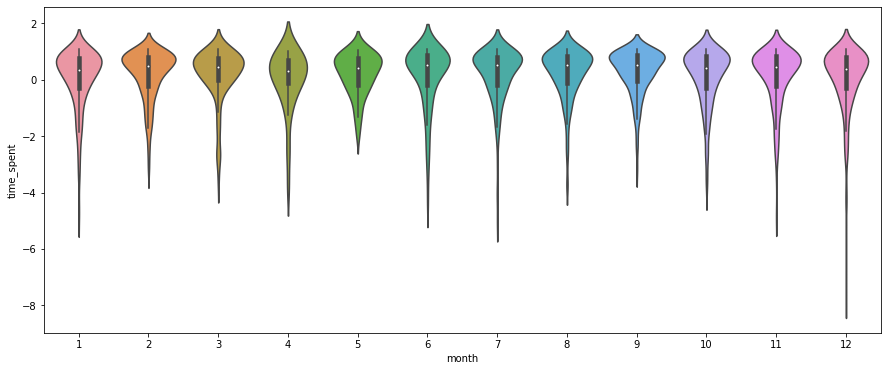

In [21]:
plt.figure(figsize = (15,6))
sns.violinplot('month',np.log(train['time_spent']),data = train)
plt.show()

###### As we can see now, we do not have any outliers and data for all months will be normally distributed due to the log transformation.

###### Creating seperate columns for device and platform

In [22]:
def new_cols(column,val):
    return [i.split('-')[val].strip() for i in column]

In [23]:
train['device'] = new_cols(train['device_details'],0)
test['device'] = new_cols(test['device_details'],0)

train['platform'] = new_cols(train['device_details'],1)
test['platform'] = new_cols(test['device_details'],1)

###### Dropping unnecessary columns

In [24]:
train.drop(['session_id','session_number','client_agent','date'],axis = 1,inplace = True)
test.drop(['session_id','session_number','client_agent','date'],axis = 1,inplace = True)

In [25]:
train

,device_details,purchased,added_in_cart,checked_out,time_spent,day,month,dayofweek,year,weekofyear,dayofyear,device,platform
0,Desktop - Chrome,1,0,0,1.373234,22,1,2,2020,4,23,Desktop,Chrome
2,iPhone - MobileWeb,0,0,0,-1.016848,1,8,3,2019,31,213,iPhone,MobileWeb
3,Desktop - IE,0,1,0,2.026395,30,12,0,2019,1,0,Desktop,IE
4,iPhone - Web,0,0,0,2.966026,10,9,1,2019,37,253,iPhone,Web
7,Android Tablet - Web,0,0,0,0.324857,3,1,4,2020,1,4,Android Tablet,Web
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,Android Tablet - Web,1,0,0,2.170036,28,2,4,2020,9,60,Android Tablet,Web
5424,iPhone - Web,0,0,0,-1.069005,20,11,2,2019,47,324,iPhone,Web
5426,Desktop - Chrome,0,0,0,-0.971495,13,8,1,2019,33,225,Desktop,Chrome
5427,Unknown - MobileWeb,0,0,0,-1.057278,18,6,1,2019,25,169,Unknown,MobileWeb


###### Let us look at the relation between time spent and purchased,added_in_cart and checked_out using facetgrid

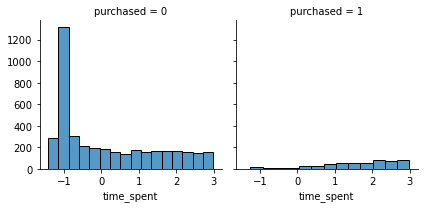

In [26]:
gg = sns.FacetGrid(train,col = 'purchased')
gg.map(sns.histplot,'time_spent')
plt.show()

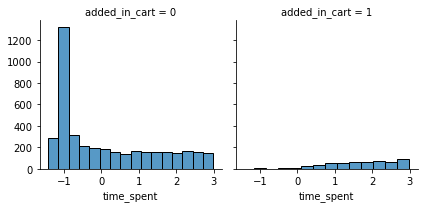

In [27]:
gg = sns.FacetGrid(train,col = 'added_in_cart')
gg.map(sns.histplot,'time_spent')
plt.show()

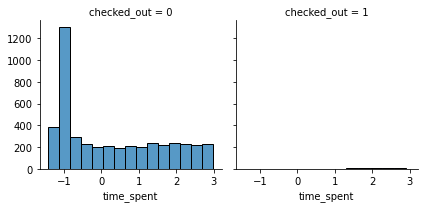

In [28]:
gg = sns.FacetGrid(train,col = 'checked_out')
gg.map(sns.histplot,'time_spent')
plt.show()

###### From the above FacetGrids it still isnt clear whether purchasing or inshort activity on the site translates to more time being spent on the site

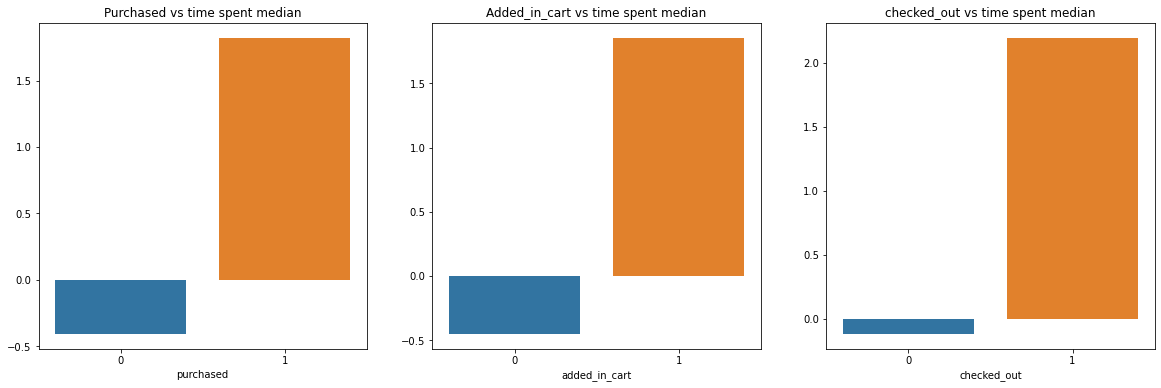

In [29]:
med_p = train.groupby('purchased')['time_spent'].median()
med_aic = train.groupby('added_in_cart')['time_spent'].median()
med_co = train.groupby('checked_out')['time_spent'].median()

fig,ax = plt.subplots(1,3,figsize = (20,6))
sns.barplot(med_p.index,med_p.values,ax = ax[0])
ax[0].set_title("Purchased vs time spent median")
sns.barplot(med_aic.index,med_aic.values,ax = ax[1])
ax[1].set_title("Added_in_cart vs time spent median")
sns.barplot(med_co.index,med_co.values,ax = ax[2])
ax[2].set_title("checked_out vs time spent median")
plt.show()

###### These graphs give us a better idea. Time_spent is related to the 3 categorical columns that were given in the original dataset. 

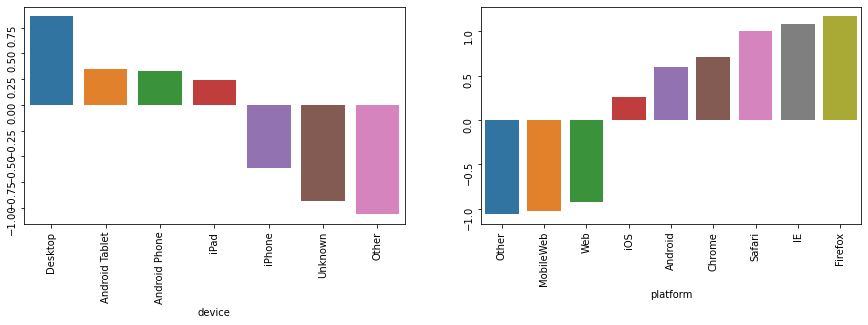

In [30]:
med_d = train.groupby('device')['time_spent'].median().sort_values(ascending = False)
med_pl = train.groupby('platform')['time_spent'].median().sort_values()
fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.barplot(med_d.index,med_d.values,ax = ax[0])
ax[0].tick_params(rotation = 90)
sns.barplot(med_pl.index,med_pl.values,ax = ax[1])
ax[1].tick_params(rotation = 90)
plt.show()

###### Consumers who use their computer seem to spend the most amount of time on the site. A similar trend with browsers. Surprising to see Internet Explorer users spending more time on the site than other browser users. Maybe the data is old.

###### Dropping device_details column

In [31]:
train.drop('device_details',axis = 1,inplace = True)
test.drop('device_details',axis = 1,inplace = True)

In [32]:
train.shape,test.shape

((4616, 12), (2327, 11))

In [33]:
train.columns,test.columns

(Index(['purchased', 'added_in_cart', 'checked_out', 'time_spent', 'day',
        'month', 'dayofweek', 'year', 'weekofyear', 'dayofyear', 'device',
        'platform'],
       dtype='object'),
 Index(['purchased', 'added_in_cart', 'checked_out', 'day', 'month',
        'dayofweek', 'year', 'weekofyear', 'dayofyear', 'device', 'platform'],
       dtype='object'))

###### Applying Anova to check which variables seems to have an impact on the dependent variable based on p-value

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import stats

$H_O$: Given categorical variables have no effect on the dependent variable.

$H_A$: Given categorical variables have a significant effect on the dependent variable.

In [35]:
model = ols("time_spent~purchased+added_in_cart+checked_out+checked_out:purchased+checked_out:added_in_cart+purchased:added_in_cart+checked_out:purchased:added_in_cart",data = train).fit()
cat = pd.DataFrame(sm.stats.anova_lm(model))
cat

,df,sum_sq,mean_sq,F,PR(>F)
purchased,1.0,1078.847238,1078.847238,797.021980,7.122866e-162
added_in_cart,1.0,1336.918086,1336.918086,987.677460,1.338175e-196
checked_out,1.0,10.376957,10.376957,7.666204,5.648972e-03
checked_out:purchased,1.0,16.904043,16.904043,12.488231,4.135431e-04
checked_out:added_in_cart,1.0,17.411354,17.411354,12.863018,3.386165e-04
purchased:added_in_cart,1.0,23.032129,23.032129,17.015488,3.772977e-05
checked_out:purchased:added_in_cart,1.0,0.709090,0.709090,0.523856,4.692383e-01
Residual,4608.0,6237.378892,1.353598,NaN,NaN


In [36]:
cat[cat.loc[:,'PR(>F)']<0.05]

,df,sum_sq,mean_sq,F,PR(>F)
purchased,1.0,1078.847238,1078.847238,797.021980,7.122866e-162
added_in_cart,1.0,1336.918086,1336.918086,987.677460,1.338175e-196
checked_out,1.0,10.376957,10.376957,7.666204,5.648972e-03
checked_out:purchased,1.0,16.904043,16.904043,12.488231,4.135431e-04
checked_out:added_in_cart,1.0,17.411354,17.411354,12.863018,3.386165e-04
purchased:added_in_cart,1.0,23.032129,23.032129,17.015488,3.772977e-05


In [37]:
train['checked_out+added_in_cart'] = train['checked_out']+train['added_in_cart']
test['checked_out+added_in_cart'] = test['checked_out']+test['added_in_cart']

#### Since all values are less than 0.05 we can reject the null hypothesis. The 3 variables have a significant effect on the categorical variable. While checked_out+added_in_cart also seems to have an impact on the dependent variable together. The other combinations seem to not create significant impact.

###### Let us check with date related columns and their impact on the independent variable.

In [38]:
model = ols("time_spent~day+month+dayofweek+year+weekofyear+dayofyear+month:day+month:year+month:dayofweek+month:weekofyear+month:dayofyear",data = train).fit()
cat = pd.DataFrame(sm.stats.anova_lm(model))
cat

,df,sum_sq,mean_sq,F,PR(>F)
day,1.0,0.174080,0.174080,0.093079,7.603127e-01
month,1.0,68.841255,68.841255,36.808789,1.407431e-09
dayofweek,1.0,0.790904,0.790904,0.422889,5.155313e-01
year,1.0,9.314934,9.314934,4.980610,2.568087e-02
weekofyear,1.0,0.407060,0.407060,0.217651,6.408575e-01
dayofyear,1.0,2.139746,2.139746,1.144102,2.848432e-01
month:day,1.0,0.901468,0.901468,0.482007,4.875497e-01
month:year,1.0,6.475827,6.475827,3.462565,6.283653e-02
month:dayofweek,1.0,3.322861,3.322861,1.776703,1.826206e-01
month:weekofyear,1.0,17.376307,17.376307,9.290952,2.315952e-03


In [39]:
cat[cat.loc[:,'PR(>F)']<0.05]

,df,sum_sq,mean_sq,F,PR(>F)
month,1.0,68.841255,68.841255,36.808789,1.407431e-09
year,1.0,9.314934,9.314934,4.980610,2.568087e-02
month:weekofyear,1.0,17.376307,17.376307,9.290952,2.315952e-03


###### Month seems to be the only column that has any impact on the dependent variable. We will drop the rest of the imputations.

In [40]:
train.drop(['day','month','year','dayofweek','weekofyear','dayofyear'],axis = 1,inplace = True)
test.drop(['day','month','year','dayofweek','weekofyear','dayofyear'],axis = 1,inplace = True)

In [41]:
train

,purchased,added_in_cart,checked_out,time_spent,device,platform,checked_out+added_in_cart
0,1,0,0,1.373234,Desktop,Chrome,0
2,0,0,0,-1.016848,iPhone,MobileWeb,0
3,0,1,0,2.026395,Desktop,IE,1
4,0,0,0,2.966026,iPhone,Web,0
7,0,0,0,0.324857,Android Tablet,Web,0
...,...,...,...,...,...,...,...
5421,1,0,0,2.170036,Android Tablet,Web,0
5424,0,0,0,-1.069005,iPhone,Web,0
5426,0,0,0,-0.971495,Desktop,Chrome,0
5427,0,0,0,-1.057278,Unknown,MobileWeb,0


### Perform One hot encoding on Device and platform variables since they are nominal and not ordinal. Label Encoding is not suitable because it would introduce magnitude into the column making it difficult for the model to generalize over the dataset.

In [42]:
device_dummies_train = pd.get_dummies(train['device'])
device_dummies_test = pd.get_dummies(test['device'])

platform_dummies_train = pd.get_dummies(train['platform'])
platform_dummies_test = pd.get_dummies(test['platform'])

device_dummies_train = device_dummies_train.drop('Unknown',axis = 1)
device_dummies_test = device_dummies_test.drop('Unknown',axis = 1)

platform_dummies_train = platform_dummies_train.drop('Other',axis = 1)
platform_dummies_test = platform_dummies_test.drop('Other',axis = 1)

train = train.drop(['device','platform'],axis = 1)
test = test.drop(['device','platform'],axis = 1)

train = pd.concat((train,device_dummies_train,platform_dummies_train),axis = 1)
test = pd.concat((test,device_dummies_test,platform_dummies_test),axis = 1)

train.shape,test.shape

((4616, 19), (2327, 18))

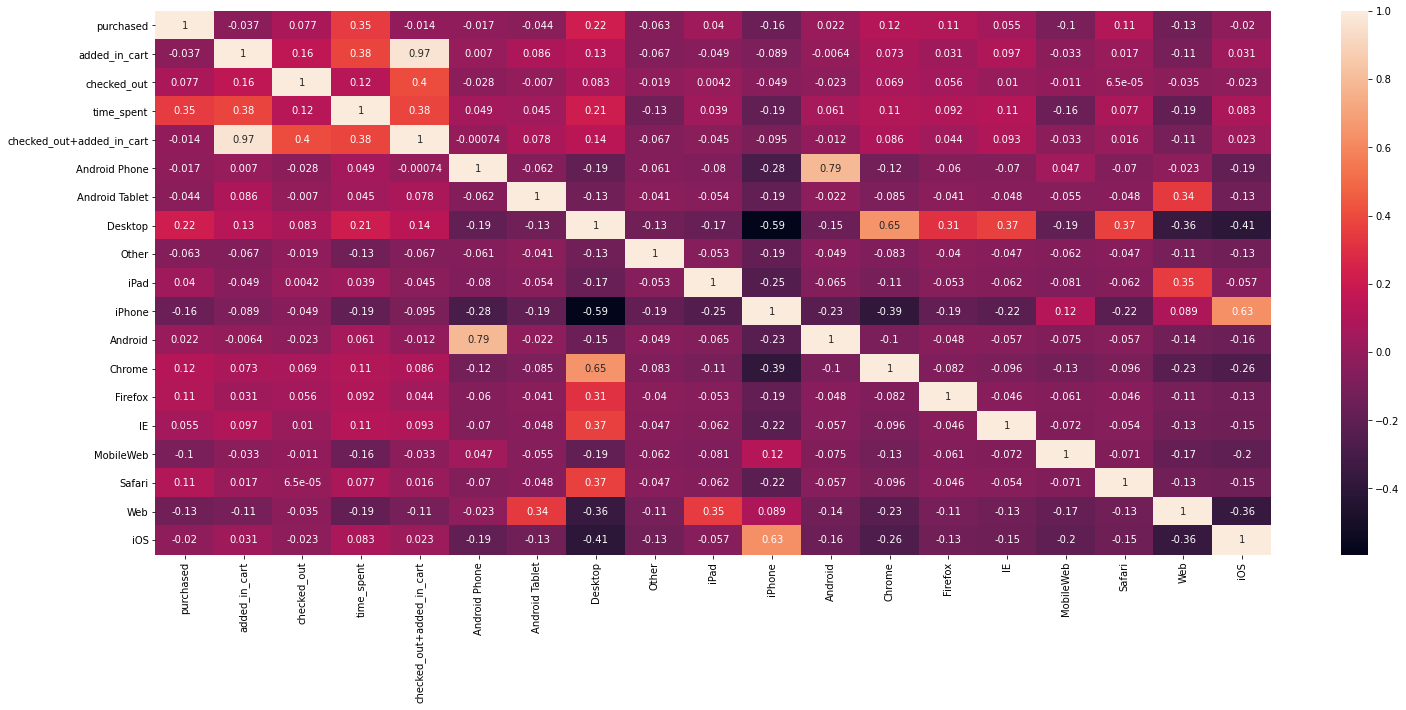

In [43]:
plt.figure(figsize = (25,10))
sns.heatmap(train.corr(),annot = True)
plt.show()

###### We should also look at the variance inflation factor to see the influence of the left over variables on other independent variables in the dataset

In [44]:
# Comment this cell out once you have finished copying.
t1 = train.copy()
t2 = test.copy()

In [45]:
train = t1
test = t2

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = train.drop('time_spent',axis= 1)
vif_data = pd.DataFrame()
vif_data['Columns'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
vif_data

C:\Users\tejas\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Columns,VIF
0,purchased,1.089976e+00
1,added_in_cart,1.808080e+07
2,checked_out,1.449516e+09
3,checked_out+added_in_cart,1.847608e+07
4,Android Phone,7.557810e+00
5,Android Tablet,3.970464e+00
6,Desktop,inf
7,Other,1.000178e+00
8,iPad,5.566347e+00
9,iPhone,1.792039e+01


###### Let us remove some columns and see whether we are able to reduce our VIF

In [47]:
train = train.drop(['checked_out+added_in_cart','Desktop','iOS'],axis = 1)
test = test.drop(['checked_out+added_in_cart','Desktop','iOS'],axis = 1)

In [48]:
train.shape,test.shape

((4616, 16), (2327, 15))

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = train.drop('time_spent',axis= 1)
vif_data = pd.DataFrame()
vif_data['Columns'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

In [50]:
vif_data

,Columns,VIF
0,purchased,1.231682
1,added_in_cart,1.237179
2,checked_out,1.046732
3,Android Phone,3.489448
4,Android Tablet,1.449946
5,Other,1.000178
6,iPad,1.466268
7,iPhone,1.683336
8,Android,3.247358
9,Chrome,1.123593


###### Now our VIF values are within an acceptable range. As a rule of thumb we should try to get our VIF value below 5 in order to be acceptable.

###### From the VIF we were getting a few infinite values. Dropping the 2 columns below reduced the outlier influence. iOS was presenting a VIF of 21. On dropping iOS we see a drastic reduction in the VIF.

# ML Modelling

###### Instead of performing standard scaler, since we know all the data is in binary form with the dependent variable only in continuous form we will  only normalize the continuous variable using a log transformation. We will create a function for the transformation to prevent the transformation from being done again and again

In [51]:
def converting_to_log(column,converted = True):
    if converted == False:
        return np.log(column)
    elif converted == True:
        return np.log(np.exp(column))

###### Applying the log transformation on the time_spent column in the train set

In [52]:
if min(train['time_spent'])<0:
    train['time_spent'] = converting_to_log(train['time_spent'],converted = True)
else:
    train['time_spent'] = converting_to_log(train['time_spent'],converted = False)

###### Create a function for the time_column conversion

In [53]:
def final_sub_conv(column):
    x = np.exp(column)
    return x*60

# ML Libraries

In [54]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LassoCV,RidgeCV,ElasticNetCV,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_log_error,make_scorer,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR

###### Create the train test split

In [55]:
ss = StandardScaler()
X = np.array(train.drop('time_spent',axis =1))
y = train['time_spent']

# Applying PCA

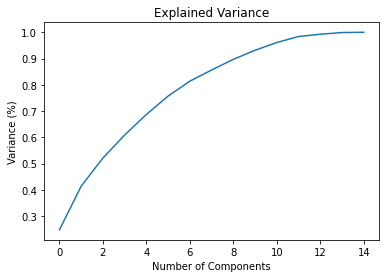

In [56]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
principalComponents = pca.fit_transform(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')

plt.show()

In [57]:
pca = PCA(n_components=11)
new_data = pca.fit_transform(X)

X = pd.DataFrame(new_data)

In [58]:
pca = PCA(n_components=11)
new_data = pca.fit_transform(test)

test = pd.DataFrame(new_data)

In [59]:
test.shape,X.shape

((2327, 11), (4616, 11))

In [60]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 3435)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3692, 11), (924, 11), (3692,), (924,))

###### Our train set columns match with the test  file that has been given for the submission purpose on which we will be making predictions. 

###### Let us create a scorer function since this hackathon uses the Mean square log error to determine the ranking.

In [61]:
def scoring(y_test,y_pred):
    return np.sqrt(mean_squared_log_error(y_test,abs(y_pred)))

###### Create a make_scorer object so that we can use it later with GridSearchCV

In [62]:
msle = make_scorer(scoring,greater_is_better = False)

###### Linear Regression

In [63]:
def modeling(function):
    lr = function
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    y_pred = final_sub_conv(y_pred)
    Y_test = final_sub_conv(y_test)
    fig,ax = plt.subplots(1,2,figsize = (15,4))
    sns.regplot(Y_test,y_pred,ax = ax[0])
    sns.kdeplot(y_pred,ax = ax[1])
    print("MSLE Score: {}\nMSE Score: {}\nMAE Score: {}".format(scoring(Y_test,y_pred),lr.score(x_test,y_test),mean_absolute_error(y_test,abs(y_pred))))

MSLE Score: 1.0977508050733802
MSE Score: 0.34901945291814057
MAE Score: 126.26246375564939


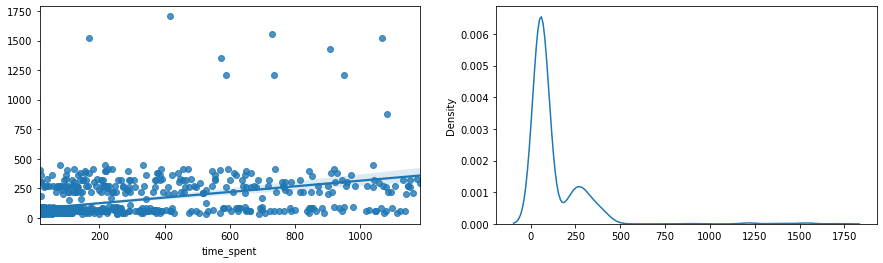

In [64]:
modeling(LinearRegression())

# Ridge

In [65]:
alphas = np.random.uniform(low=0, high=10, size=(50,))
ridgecv = RidgeCV(alphas = alphas,cv=10,normalize = True)
ridgecv.fit(x_train, y_train)

RidgeCV(alphas=array([5.15577224, 6.43067269, 9.3368537 , 9.33421006, 5.20449143,
       3.35790935, 2.64072773, 7.795158  , 5.40358591, 9.87019428,
       4.50557655, 2.4827204 , 1.37237105, 8.91585238, 9.23981406,
       2.37317067, 6.48918004, 4.5858933 , 1.24487351, 0.02614928,
       5.54906373, 1.61494268, 4.2285701 , 5.01406524, 2.08623338,
       2.01522903, 1.14601867, 6.62998676, 5.59771513, 5.34692678,
       6.51119049, 3.39581236, 5.55394732, 3.32334113, 8.04553924,
       4.42944439, 0.35411381, 1.91780464, 9.70105432, 7.94057017,
       9.37874871, 8.74808978, 2.8710057 , 0.3194008 , 5.58056547,
       2.36324132, 5.76014119, 1.36413441, 0.15836042, 7.94157787]),
        cv=10, fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
        store_cv_values=False)

In [66]:
alpha = ridgecv.alpha_
alpha

0.02614928448700371

MSLE Score: 1.097750937283811
MSE Score: 0.34901910676809433
MAE Score: 126.25497707492147


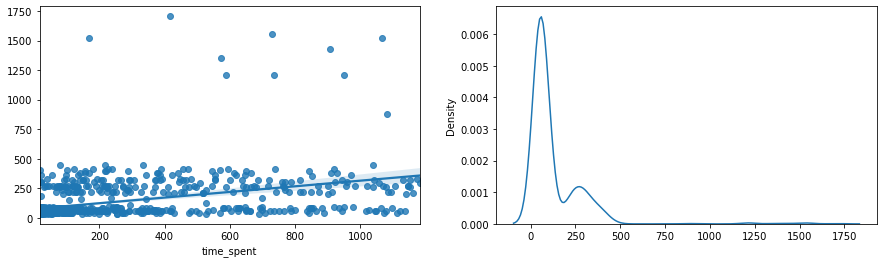

In [67]:
modeling(Ridge(alpha))

# Lasso

In [68]:
lasscv = LassoCV(alphas = None,cv =10, max_iter = 100000, normalize = True)
lasscv.fit(x_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [69]:
alpha = lasscv.alpha_
alpha

9.51257957637087e-06

MSLE Score: 1.0977491411439766
MSE Score: 0.34902117937799026
MAE Score: 126.2524634768175


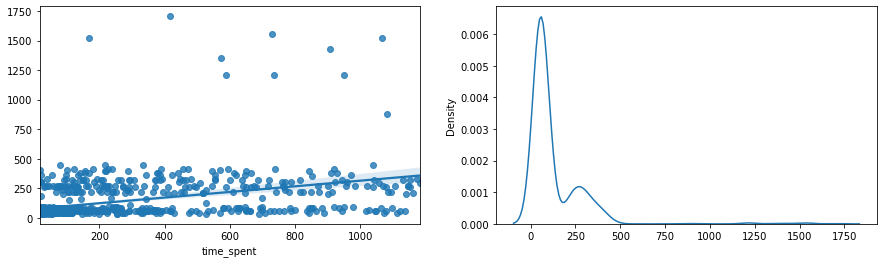

In [70]:
modeling(Lasso(alpha))

# Elastic Net

In [71]:
elasticCV = ElasticNetCV(alphas = None, cv =10)
elasticCV.fit(x_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [72]:
alpha = elasticCV.alpha_
l1 = elasticCV.l1_ratio
l1,alpha

(0.5, 0.00041786272096673886)

MSLE Score: 1.0977252331941676
MSE Score: 0.34903880225000417
MAE Score: 125.82504121354849


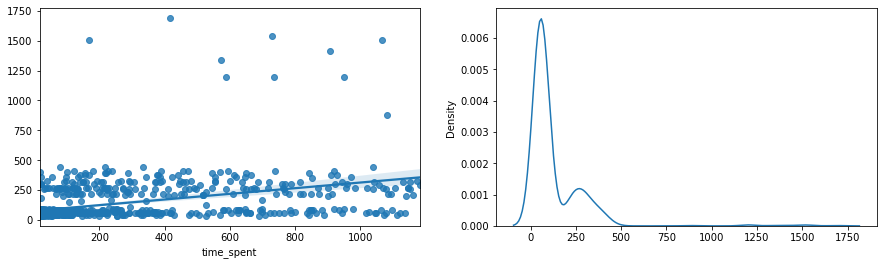

In [73]:
modeling(ElasticNet(alpha = alpha,l1_ratio = l1))

###### Overall we are seeing similar scores with all 4 regression methods. This means that there is no overfitting in the dataset. We will move onto more advance models ahead.

# Decision Trees

In [74]:
grid_param = {
    'criterion': ['mse', 'mae'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
    
}

In [75]:
# grid_search.best_params_

In [76]:
# grid_search = GridSearchCV(estimator=DecisionTreeRegressor(),
#                      param_grid=grid_param,scoring = msle,
#                      cv=5,
#                     n_jobs =-1,verbose=3)
# grid_search.fit(x_train,np.exp(y_train))

In [77]:
# grid_search.best_params_

In [78]:
bp = {'criterion': 'mae',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'splitter': 'random'}

MSLE Score: 1.1519483915067767
MSE Score: 0.28560568168809086
MAE Score: 107.48881543682583


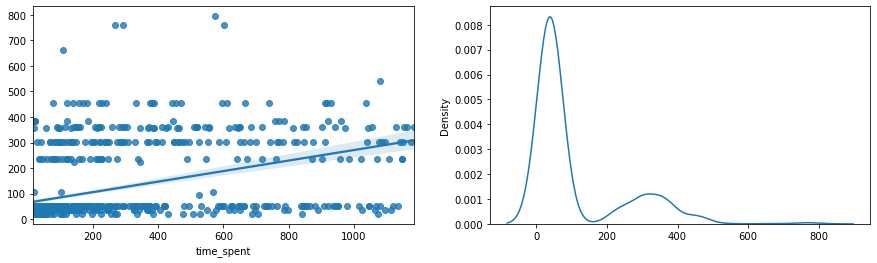

In [79]:
modeling(DecisionTreeRegressor(criterion = bp['criterion'],max_depth = bp['max_depth'],min_samples_leaf = bp['min_samples_leaf'],min_samples_split = bp['min_samples_split'],splitter = bp['splitter']))

Decision trees is not able to generalize as well. We will try with random forests next. Decision trees usually tend to overfit over train set. This makes it difficult to predict over unseen data when using Decision Trees. Random Forests can solve this problem since it introduces more randomness into the data. We randomly select samples for our bootstraped dataset. Randomly select 2 nodes for the root node and split creating leaves of trees.

# Random Forest

In [80]:
bp

{'criterion': 'mae',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'splitter': 'random'}

In [81]:
grid_param = {
    "n_estimators" : [130,135,140,145,150],
    'criterion': ['mse', 'mae'],
    'min_samples_leaf' : [11,12,13],
    'min_samples_split': [11,12,13],
    'max_features' : ['auto','log2']
}

In [82]:
# grid_search = GridSearchCV(estimator=RandomForestRegressor(),
#                      param_grid=grid_param,
#                      cv=5,
#                     n_jobs =-1,verbose=3,scoring = msle)
# grid_search.fit(x_train,np.exp(y_train))

In [83]:
# grid_search.best_params_

In [84]:
# bp = {'criterion': 'mae',
#  'max_features': 'log2',
#  'min_samples_leaf': 12,
#  'min_samples_split': 12,
#  'n_estimators': 135}

In [85]:
bp = {'criterion': 'mae',
 'max_features': 'log2',
 'min_samples_leaf': 12,
 'min_samples_split': 12,
 'n_estimators': 135}

MSLE Score: 1.1205848262034233
MSE Score: 0.3237091166705278
MAE Score: 114.12700957385924


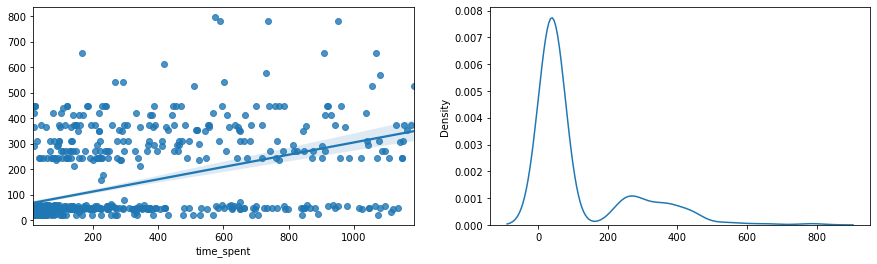

In [86]:
modeling(RandomForestRegressor(criterion = bp['criterion'],max_features = bp['max_features'],min_samples_leaf = bp['min_samples_leaf'],min_samples_split = bp['min_samples_split'],random_state = 6))

# Bagging

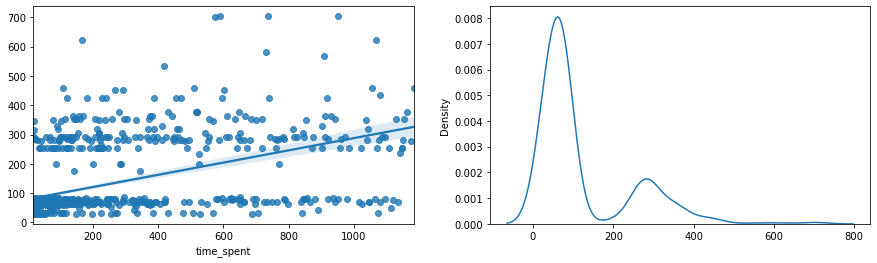

MSLE Score: 1.0740024510419766
MSE Score: 0.37714087962794285
MAE Score: 122.23332282105869


In [87]:
bag_rand = BaggingRegressor(RandomForestRegressor(n_estimators = 250,min_samples_split = 25,min_samples_leaf = 8))
bag_rand.fit(x_train,y_train)
y_pred = bag_rand.predict(x_test)
y_pred = final_sub_conv(y_pred)
Y_test = final_sub_conv(y_test)

fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.regplot(Y_test,y_pred,ax = ax[0])
sns.kdeplot(y_pred,ax = ax[1])
plt.show()
print("MSLE Score: {}\nMSE Score: {}\nMAE Score: {}".format(scoring(Y_test,y_pred),bag_rand.score(x_test,y_test),mean_absolute_error(y_test,abs(y_pred))))

In [88]:
# pred = bag_rand.predict(test)
# final_pred = final_sub_conv(pred)
# predictions = pd.DataFrame(final_pred,columns = ['time_spent'])
# predictions.to_csv('Submissions/timehr.csv',index = False)

# Adaboost

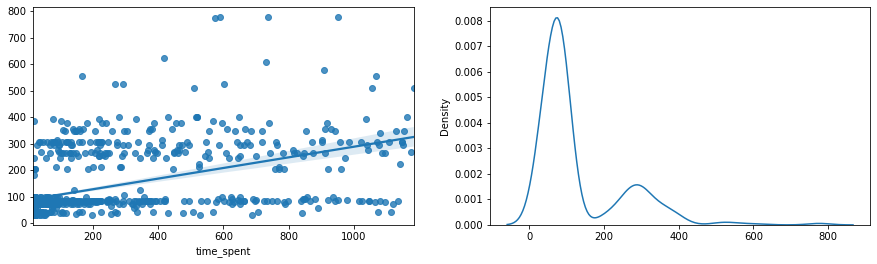

MSLE Score: 1.0969009857720542
MSE Score: 0.37714087962794285
MAE Score: 129.7686861981251


In [89]:
abt = AdaBoostRegressor(RandomForestRegressor(n_estimators = 250,min_samples_split = 25,min_samples_leaf = 8,random_state = 6))
abt.fit(x_train,y_train)
y_pred = abt.predict(x_test)
y_pred = final_sub_conv(y_pred)
Y_test = final_sub_conv(y_test)
fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.regplot(Y_test,y_pred,ax = ax[0])
sns.kdeplot(y_pred,ax = ax[1])
plt.show()
print("MSLE Score: {}\nMSE Score: {}\nMAE Score: {}".format(scoring(Y_test,y_pred),bag_rand.score(x_test,y_test),mean_absolute_error(y_test,abs(y_pred))))

In [90]:
# pred = abt.predict(test)
# final_pred = final_sub_conv(pred)
# predictions = pd.DataFrame(final_pred,columns = ['time_spent'])
# predictions.to_csv('Submissions/abttimehr.csv',index = False)

# GradientBoostingRegressor

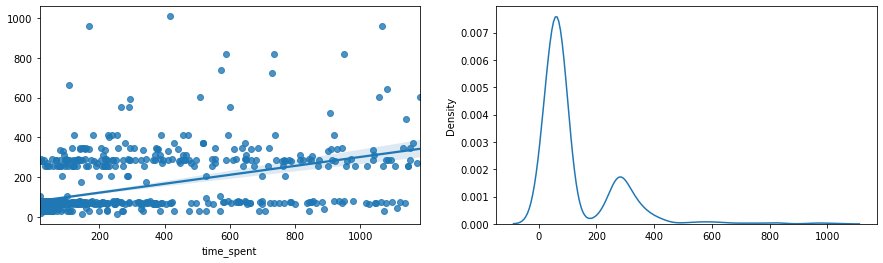

MSLE Score: 1.071850100998661
MSE Score: 0.37714087962794285
MAE Score: 124.01270154193064


In [124]:
gbr = GradientBoostingRegressor(learning_rate = 1.15)
gbr.fit(x_train,y_train)
y_pred = gbr.predict(x_test)
y_pred = final_sub_conv(y_pred)
Y_test = final_sub_conv(y_test)
fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.regplot(Y_test,y_pred,ax = ax[0])
sns.kdeplot(y_pred,ax = ax[1])
plt.show()
print("MSLE Score: {}\nMSE Score: {}\nMAE Score: {}".format(scoring(Y_test,y_pred),bag_rand.score(x_test,y_test),mean_absolute_error(y_test,abs(y_pred))))

# XGBoost

In [ ]:
param_g = {
    'n_estimators': [50,100,150,200],
    'max_depth':[4,5,6,7,8],
    'learning_rate':[1,0.1,0.01,0.001],
    
    
}

In [ ]:
grid_search = GridSearchCV(XGBRegressor(),)

MSLE Score: 1.0699214543788553
MSE Score: 0.3819201289234058
MAE Score: 123.70731412488942


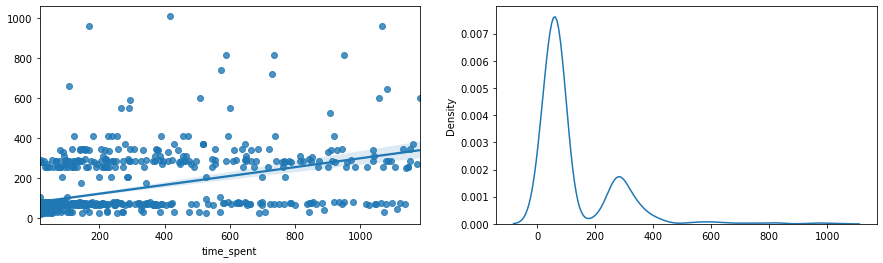

In [122]:
modeling(XGBRegressor(learning_rate = 1.15,max_depth = 10,booster = 'gbtree'))

In [128]:
xgb_reg = XGBRegressor(learning_rate = 1.15,max_depth = 10,booster = 'gbtree')
xgb_reg.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1.15, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [133]:
predictions = xgb_reg.predict(test)
predictions = final_sub_conv(y_pred)
p = pd.DataFrame(predictions,columns = ['time_spent'])
p.to_csv('Submissions/xgbpca.csv',index = False)

# SVM

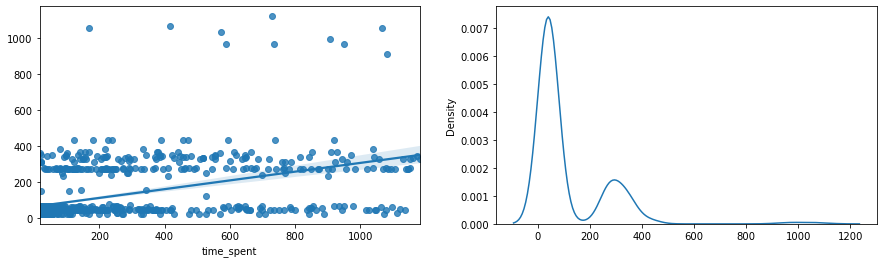

MSLE Score: 1.1137629855694768
MSE Score: 0.37714087962794285
MAE Score: 112.46401474444816


In [93]:
s = SVR()
s.fit(x_train,y_train)
y_pred = s.predict(x_test)
y_pred = final_sub_conv(y_pred)
Y_test = final_sub_conv(y_test)
fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.regplot(Y_test,y_pred,ax = ax[0])
sns.kdeplot(y_pred,ax = ax[1])
plt.show()
print("MSLE Score: {}\nMSE Score: {}\nMAE Score: {}".format(scoring(Y_test,y_pred),bag_rand.score(x_test,y_test),mean_absolute_error(y_test,abs(y_pred))))